In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## This configuration is for the Multi Channel Neural network

In [2]:
import csv
df = pd.read_csv('quantum_harmonic_oscillator_timed_data.csv')
print("Dataset shape ", df.shape)

Dataset shape  (700000, 201)


1st column is time. The next 100 columns form initial data, and the final 100 forms the final data. For train-test split, we are taking the first 20% and last 20% rows (excluding the first column) to test and the middle 60% (excluding the first column) for training

In [3]:
marker_1 = int(0.2 * len(df))
marker_2 = int(0.8 * len(df))

# Split into training and testing data
train_data = df.iloc[marker_1:marker_2]
test_data = pd.concat([df.iloc[:marker_1], df.iloc[marker_2:]])

# Verifying shapes
print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
print()

# TIME DATA
T = df.iloc[:, 0]
time_train = T.iloc[marker_1:marker_2]
time_test = pd.concat([T.iloc[:marker_1], T.iloc[marker_2:]])
print("Shape of train time", time_train.shape)
print("Shape of test time", time_test.shape)
print()


# TRAINING DATA
feat_train = train_data.iloc[:, 1:101].values  # 1 to 101 columns are features
targ_train = train_data.iloc[:, 101:].values  # the next 100 columns are targets

# TESTING DATA
feat_test = test_data.iloc[:, 1:101].values
targ_test = test_data.iloc[:, 101:].values

# Verifying shapes
print("Shape of feat_train:", feat_train.shape)
print("Shape of targ_train:", targ_train.shape)
print("Shape of feat_test:", feat_test.shape)
print("Shape of targ_test:", targ_test.shape)

Shape of train_data: (420000, 201)
Shape of test_data: (280000, 201)

Shape of train time (420000,)
Shape of test time (280000,)

Shape of feat_train: (420000, 100)
Shape of targ_train: (420000, 100)
Shape of feat_test: (280000, 100)
Shape of targ_test: (280000, 100)


Reshaping time data

In [4]:
time_train = time_train.values.reshape(-1, 1)
time_test = time_test.values.reshape(-1,1)
print(time_train.shape)
print(time_test.shape)

(420000, 1)
(280000, 1)


In [6]:
# Convert strings to complex numbers
time_train_tensor = np.vectorize(complex)(time_train)
time_test_tensor = np.vectorize(complex)(time_test)
F_train = np.vectorize(complex)(feat_train)
T_train = np.vectorize(complex)(targ_train)
F_test = np.vectorize(complex)(feat_test)
T_test= np.vectorize(complex)(targ_test)

In [7]:
# Convert numpy arrays to PyTorch tensors
time_train_tensor = torch.tensor(time_train_tensor, dtype = torch.complex64)
time_test_tensor = torch.tensor(time_test_tensor, dtype = torch.complex64)
F_train_tensor = torch.tensor(F_train, dtype = torch.complex64)
T_train_tensor = torch.tensor(T_train, dtype = torch.complex64)
F_test_tensor = torch.tensor(F_test, dtype = torch.complex64)
T_test_tensor = torch.tensor(T_test, dtype = torch.complex64)
print(time_test_tensor.shape, time_train_tensor.shape)
print(time_test_tensor.dtype)

torch.Size([280000, 1]) torch.Size([420000, 1])
torch.complex64


Setting up neural networks

In [8]:
torch.seed()

class SGDRegressionPosition(nn.Module):
    def __init__(self):
        super(SGDRegressionPosition, self).__init__()
        self.fc1 = nn.Linear(100, 400, dtype = torch.complex64)  # Input layer [100 input]
        self.fc2 = nn.Linear(400, 50,  dtype = torch.complex64)  # Hidden layer 1
        self.fc3 = nn.Linear(50, 400,  dtype = torch.complex64)  # Hidden layer 2
        self.fc4 = nn.Linear(400, 100,  dtype = torch.complex64)   # Output layer [100 output]

    def forward(self, x):
        x = torch.tanh(self.fc1(x))  
        x = torch.tanh(self.fc2(x)) 
        x = torch.tanh(self.fc3(x))  
        x = self.fc4(x)
        return x
    
class SGDRegressionTime(nn.Module):
    def __init__(self):
        super(SGDRegressionTime, self).__init__()
        self.fc1 = nn.Linear(1, 100, dtype = torch.complex64)  # Input layer [1 input]
        self.fc2 = nn.Linear(100, 5,  dtype = torch.complex64)  # Hidden layer 1
        self.fc3 = nn.Linear(5, 50,  dtype = torch.complex64)  # Hidden layer 2
        self.fc4 = nn.Linear(50, 1,  dtype = torch.complex64)   # Output layer [1 output]

    def forward(self, x):
        x = torch.tanh(self.fc1(x))  
        x = torch.tanh(self.fc2(x)) 
        x = torch.tanh(self.fc3(x))  
        x = self.fc4(x)
        return x
    
class MultiChannelNN(nn.Module):
    def __init__(self):
        super(MultiChannelNN, self).__init__()
        self.position_net = SGDRegressionPosition()
        self.time_net = SGDRegressionTime()
        
        self.fc_combined1 = nn.Linear(101, 10, dtype=torch.complex64)  # input Layer [ Total 101 input ]
        self.fc_combined2 = nn.Linear(10, 100, dtype = torch.complex64) # output Layer [ 100 output ]

    def forward(self, position_input, time_input):
        position_output = self.position_net(position_input)
        time_output = self.time_net(time_input)
        
        combined_input = torch.cat((position_output.view(-1, 100), time_output.view(-1, 1)), dim=1)
        
        combined_output = torch.tanh(self.fc_combined1(combined_input))
        combined_output = self.fc_combined2(combined_output)
        
        return combined_output
#weaving method

Loss function: Since we have complex numbers, we use conjugates to calculate the mean squared error loss

In [19]:
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, data_preds, data_targs):
        # data loss
        diff = data_preds - data_targs
        diff_dag = torch.conj(diff)
        loss_data = torch.mean(diff*diff_dag)
        return loss_data.float()

Within the training loop, we implement mini-batch gradient descent.

In [26]:
#from tensorboardX import SummaryWriter
BATCH_SIZE = 12 #change this
EPOCHS = 2 #1000s of epochs
LR = 0.01

train_data = torch.utils.data.TensorDataset(F_train_tensor, time_train_tensor, T_train_tensor)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

size = len(data_loader.dataset)
model = MultiChannelNN()
loss_fn = CustomLoss() 
optimizer = optim.Adam(model.parameters(), lr=LR)
losses = []
    
for epoch in range(EPOCHS):
    for batch, (input_data, time_col, output_data) in enumerate(data_loader):

        pred = model(input_data, time_col)
        loss = loss_fn(pred, output_data)
        losses.append(loss.item())
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        
print("Done")
#i and r instead of x and y

Done


Graphing Loss function

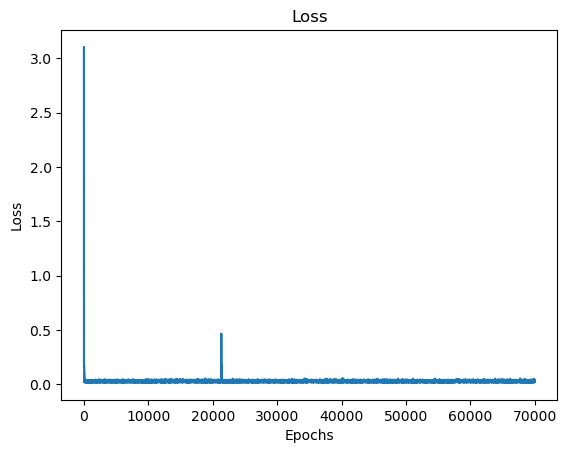

In [27]:
EPOCHS = list(range(1, len(losses) + 1))
plt.plot(EPOCHS, losses)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Model Evaluation: Here, we randomly sample num_samples number of distributions from the testing data and plot it to view performance of the model.

[ 12923  52008 203992 144278 189866]


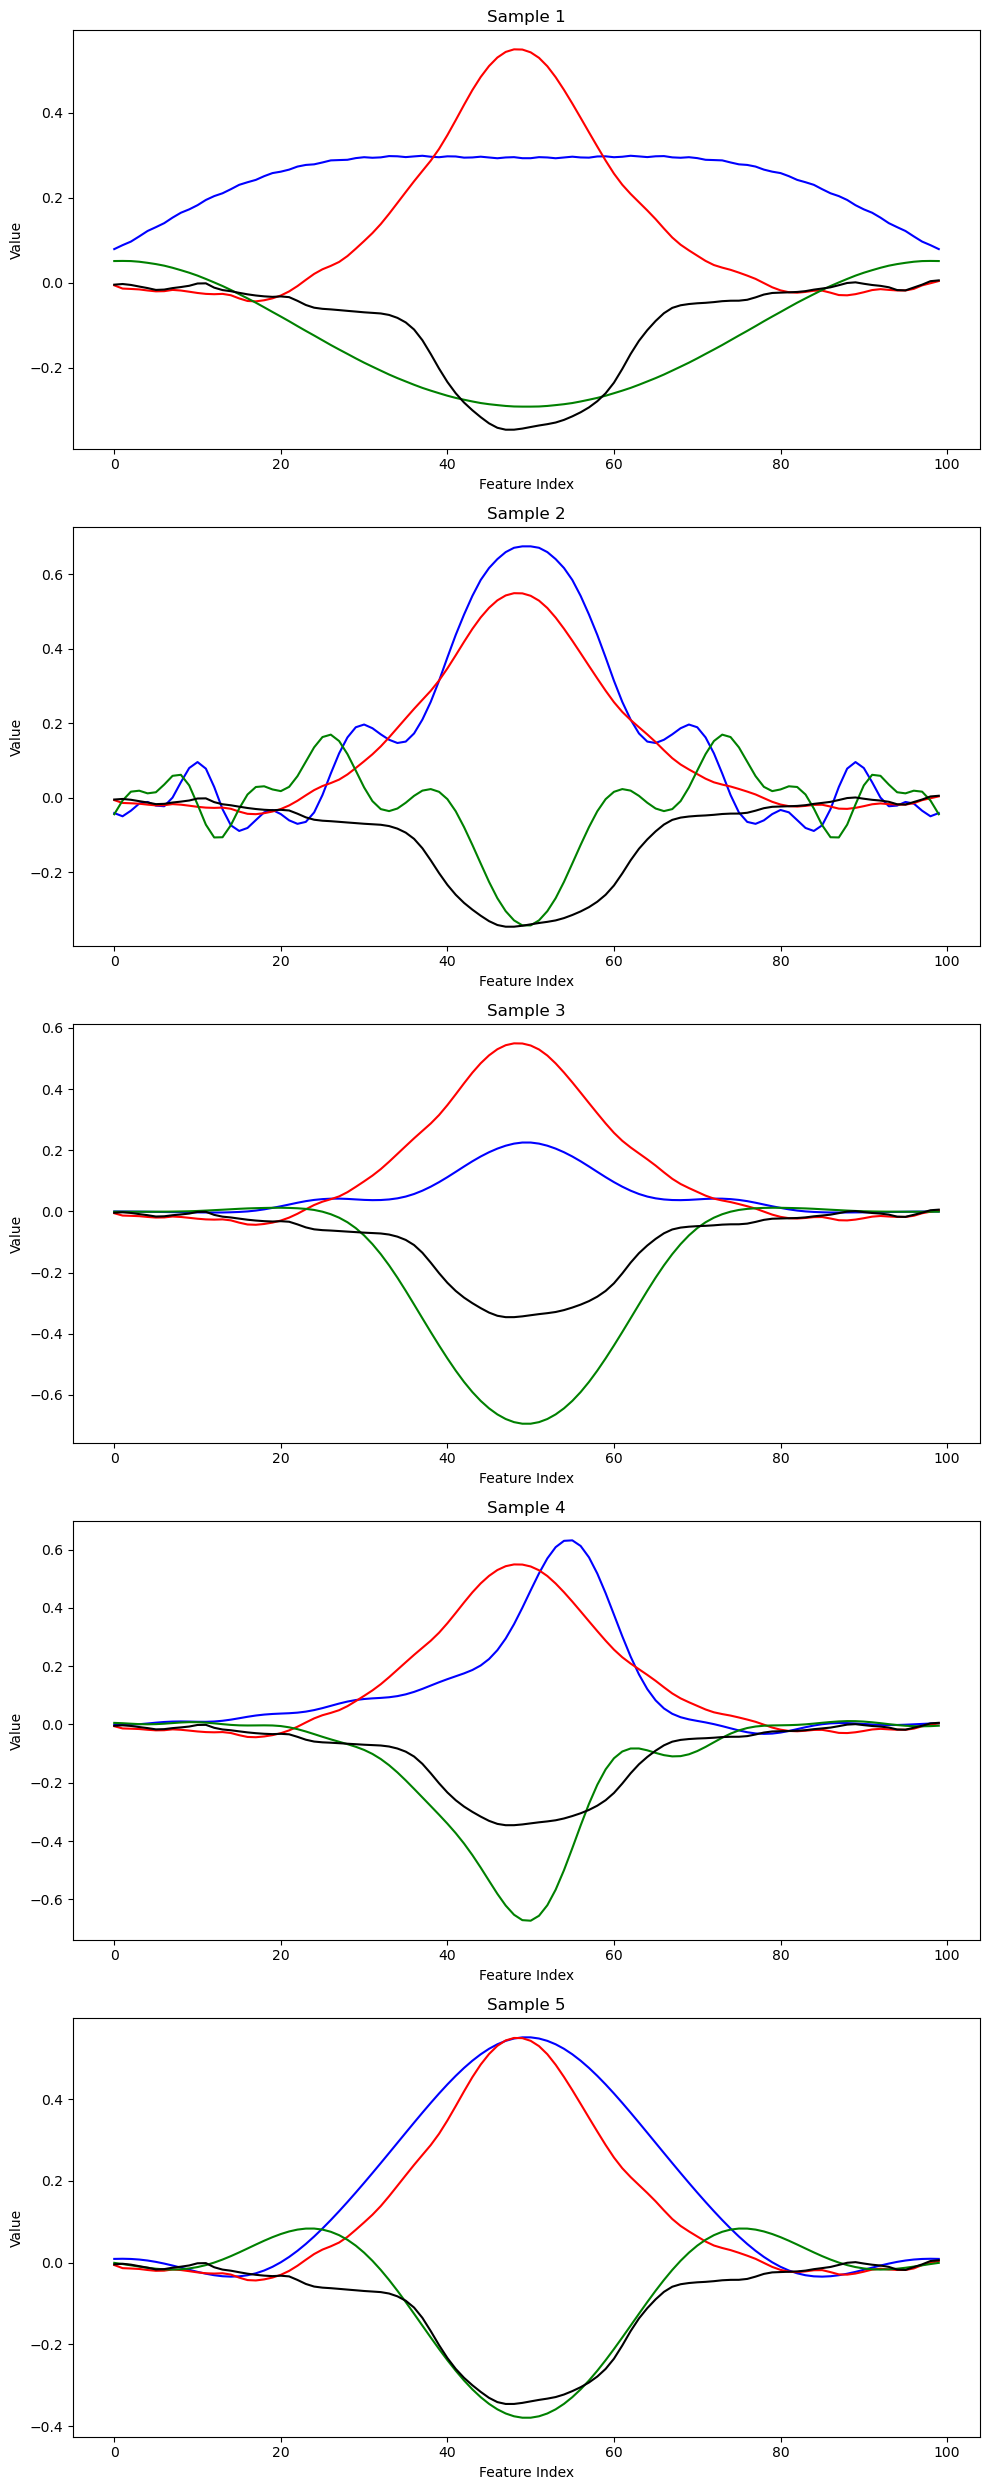

In [33]:
# Randomly select a subset of the test data
#Evaluating
model.eval()
with torch.no_grad():
    test_pred = model(F_test_tensor, time_test_tensor)
test_pred = test_pred.numpy()

num_samples = 5  # Number of samples to plot
indices = np.random.choice(F_test_tensor.shape[0], num_samples)
print(indices)

# Get the true and predicted values for these indices
true_values = T_test_tensor[indices].numpy()
predicted_values = test_pred[indices]

# Plotting the results
fig, axs = plt.subplots(num_samples, 1, figsize=(10, 5 * num_samples))

for i in range(num_samples):
    axs[i].plot(range(100), true_values[i], color='blue', label='True Values')
    axs[i].plot(range(100), predicted_values[i], color='red', label='Predicted Values')
    axs[i].plot(range(100), true_values[i].imag, color='green', label='True Values')
    axs[i].plot(range(100), predicted_values[i].imag, color='black', label='Predicted Values')
    axs[i].set_title(f'Sample {i+1}')
    axs[i].set_xlabel('Feature Index')
    axs[i].set_ylabel('Value')
    #axs[i].legend()

plt.tight_layout()
plt.show()